In [1]:
import rasterio

def get_geotiff():
    with rasterio.open("ahn3.tif") as src:
        elev_data = src.read(1)
        # replace all 1e38 values with 0
        elev_data[elev_data >= 1e37] = 0
        return elev_data


In [2]:
def find_highest_point(file_path):
    elev_data = get_geotiff()

    # find the maximum elevation value and its corresponding location
    max_elev = np.amax(elev_data)
    max_loc = np.unravel_index(np.argmax(elev_data, axis=None), elev_data.shape)

    return max_elev, max_loc[0], max_loc[1]

In [3]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.warp import transform

def preview_geotiff_with_dots(file_path, locations):
    elev_data = get_geotiff()

    # get the minimum and maximum values of the elevation data
    elev_min = np.nanmin(elev_data)
    elev_max = np.nanmax(elev_data)

    # create a Matplotlib figure and axis objects
    fig, ax = plt.subplots(figsize=(12, 12))

    # plot the elevation data as an image
    im = ax.imshow(elev_data, cmap='terrain', vmin=elev_min, vmax=elev_max)

    # add a colorbar to the plot
    cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)

    # add dots at the specified locations
    for location in locations:
        x, y = location[0], location[1]
        ax.scatter(x, y, s=50, c='red', marker='o')

        for angle in range(0,360,5):
            draw_ray_to_higher_altitude(ax, elev_data, x, y, angle)

    # set the plot title and axis labels
    ax.set_title("AHN3 Elevation Data with Dot")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")

    # display the plot
    plt.show()
    


In [13]:
import numpy as np

def draw_ray_to_higher_altitude(ax, elev_data, x, y, angle):
    # get the elevation at the location
    loc_elev = elev_data[y, x]

    # calculate the slope of the ray
    slope = np.tan(np.deg2rad(angle))

    # calculate the direction of the ray
    if angle > 90 and angle <= 270:
        x_dir = -1
    else:
        x_dir = 1

    if angle > 0 and angle <= 180:
        y_dir = -1
    else:
        y_dir = 1

    # start the ray at the location
    ray_x, ray_y = x, y

    # move the ray one pixel at a time until it hits a point at a higher altitude
    while True:
        # calculate the next pixel location along the ray
        next_x = ray_x + x_dir
        next_y = ray_y + y_dir * slope

        # check if the next pixel is out of bounds
        if next_x < 0 or next_x >= elev_data.shape[1] or next_y < 0 or next_y >= elev_data.shape[0]:
            break

        # check if the next pixel is at a higher altitude
        if elev_data[int(next_y), next_x] > loc_elev:
            break

        # update the ray position
        ray_x, ray_y = next_x, next_y

    # if the ray hit a point at a higher altitude, plot a line from the location to that point
    if ray_x >= 0 and ray_x < elev_data.shape[1] and ray_y >= 0 and ray_y < elev_data.shape[0]:
        ax.plot([x, ray_x], [y, ray_y], color='yellow', linewidth=1, alpha=0.35)


In [14]:
def get_sample_grid_locations(file_name, n=10):
    elev_data = get_geotiff()
    
    shape = elev_data.shape

    num_rows = n
    num_cols = n
    row_step = shape[0] // num_rows
    col_step = shape[1] // num_cols
    locations = []
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            row_start = row_idx * row_step
            col_start = col_idx * col_step
            x = col_start + col_step // 2
            y = row_start + row_step // 2
            locations.append((x, y))
    
    return locations

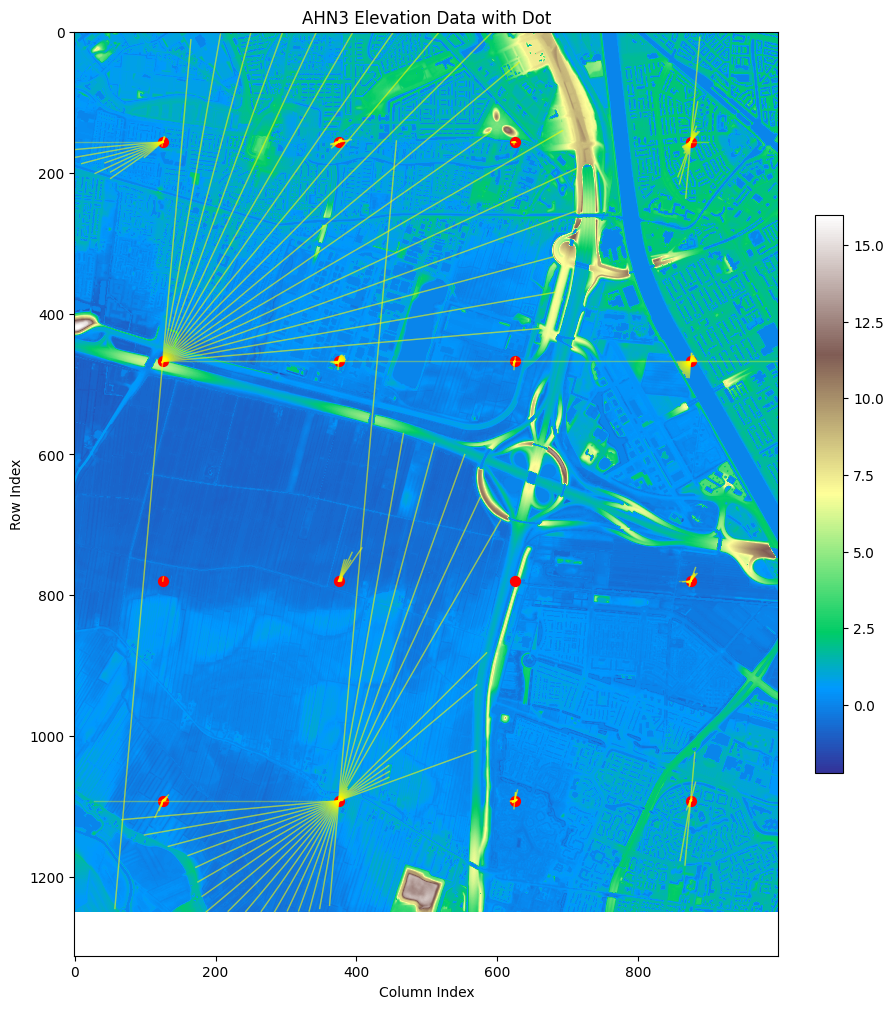

In [15]:
locations = get_sample_grid_locations("ahn3.tif", 4)
preview_geotiff_with_dots("ahn3.tif", locations)


